# Deep Q-Learning

January 4, 2022 by Lars Quaedvlieg

<div class="alert alert-block alert-danger">
<b>TODO:</b><br>
Cite when converting too Jupyter book<br>
For self: What to talk about? DQN -> R2D2 -> NGU -> Agent57 (might take too much time?) -> AlphaGo -> AlphaZero -> MuZero (leave out implementation?)<br>
Add images<br>
Cool Deep RL chapter image<br>
For DQN experiments, also track maximum action-values<br>
Add t-SNE embedding?<br>
Soft updates for policy to target net?<br>
Loss clipping???
</div>

In this first notebook, we will implement multiple algorithms having to do with Deep RL, and apply them to a cool environment. We will start with one of the algorithms which got Deep RL taking off, namely, Deep Q-Learning. Then we will address some of the issues that come with this algorithm and improve it even more. This will hopefully also highlight progression in the field.

>The original paper introducing Deep Q-Learning, was published by authors from Google DeepMind back in 2015. Its title: **"Human-level control through deep reinforcement
learning"**. In this section, we explain how DQL was invented from tabular Q-Learning, show how one can implement the algorithm, and how to apply it to a problem.

As was the case with tabular Q-Learning, a Markov Decision Process can be represented as a tuple $MDP = (S,A,P,R,\gamma)$. Q-Learning is an off-policy method, following a behavioral policy $\mu(.|S_t)$, but an alternative sucessor action $A' \sim \pi(.|S_t)$ is also considered. $Q(S_t|A_t)$ will then be updated towards the value of the alternative action: $Q_{k+1}(S_t, A_t) = Q_k(S_t, A_t) + \alpha(R_{t+1} + \gamma Q_k(S_{t+1}, A') - Q_k(S_t, A_t))$.

Now, allow both policies to be able to improve: $\pi(S_{t+1}) = \arg\max_{a'}Q(S_{t+1}, a')$, and $\mu = \epsilon$-$greedy(Q)$. In this case, the Q-Learning target simplifies to $R_{t+1} + \gamma Q(S_{t+1}, A') = R_{t+1} + \gamma \max_{a'} Q(S_{t+1}, a')$.

This gives rise to the Q-Learning update rule: $Q_{S_t, A_t} = Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_{A_{t+1}} Q(S_{t+1}, A_{t+1})]$. With proper hyperparameters, this algorithm is guaranteed to converge to the optimal policy $Q_i \rightarrow Q^*(s, a) = \max_\pi E_\pi\left[R_t|s_t=s, a_t=a\right]$ as $i \rightarrow \infty$.

However, this algorithm is totally impractical, since this update rule has to be performed for every possible tuple $(s, a) \in S \times A$. In practical scenarios, the dimensionality of the state-space (or action-space, think about continuous action spaces) make it computationally impossible to run this algorithm for even one iteration. If we could generalize learning to more than this *one* tuple $(S, A)$ at once, we would be able to use this method much more easily.

This is where *function approximators* come in! The idea is to parameterize the Q-value function with parameterization $\theta$: $Q(s, a; \theta) \approx Q^*(s, a)$. When this idea was introduced, linear approximators were mostly used. For example, think about a linear combination of features and weights to estimate the Q-values. Using one-hot-encodings as input for your state space to such an approximator, it can be shown that function approximation is a generalization of tabular Q-Learning.

Sometimes non-linear estimators for the action-value function were used, such as a neural network. This neural networks with weights $\theta$ is referred to as a Q-Network. A Q-Network can be trained by minimizing loss-functions $L_i(\theta_i))$ which changes at every iteration $i$ due to the expectation you will see.

$$
    L_i(\theta_i) = E_{s, a \sim\rho(.)}\left[(y_i - Q(s, a; \theta_i))^2\right]
$$

Here $y_i = E_{r, s' \sim P}\left[r + \gamma \max_{a'}Q(s', a'; \theta_{i-1})|s, a\right]$ is a target at iteration $i$. It is our goal to minimize this loss function, which can be done with the use of gradient-based optimization. Differentiating the loss function w.r.t. the weight results in:

$$
    \nabla_{\theta_i} L_i(\theta_i) = E_{s, a \sim \rho(.);r, s' \sim P}\left[\left(r + \gamma \max_{a'}Q(s', a'; \theta_{i-1}) - Q(s, a; \theta_i)\right)\nabla_{\theta_i}Q(s, a; \theta_i)\right]
$$

Instead of computing the entire expectation in this gradient, it is often easier to minimize the loss function using stochastic gradient descent. These weights are then updated at each iteration, and the expectation is replaced by single samples from $\rho$. This is what happens in the original Q-Learning algorithm.

The big problem is the fact that non-linear gradient-based Q-Learning does not necessarily convergence; this is actually the reason linear approximation was focused on within research: it has better convergence properties. All Deep Reinforcement Learning algorithms, Deep Q-Learning included, aim to "push" algorithms more towards convergence using clever (and often mathematically sound) tricks. We are now ready to get into the techniques introduced in the Deep Q-Learning paper.

First, let's import some of the libraries we will be using, and initialize a __[Pytorch device](https://pytorch.org/docs/stable/notes/cuda.html)__. for computations (GPU when possible, else CPU).

In [1]:
# Import copy for creating deep copies, and time for measuring elapsed time during training 
import copy
import time

# Import OpenAI Gym for Reinforcement Learning environments, numpy for efficient computations
import gym
import numpy as np

# Import Pytorch neural networks and optimizers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import pandas and seaborn for saving/visualizing the results
import pandas as pd
import seaborn as sns

# Check if we can use a GPU for computations (requires CUDA support)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('GPU available:', torch.cuda.is_available())
print('Using device:', device)

if device.type == 'cuda':
    print('Device name:', torch.cuda.get_device_name(device))

GPU available: True
Using device: cuda
Device name: NVIDIA GeForce GTX 1060 with Max-Q Design


### The Replay Buffer

The technique utilized by the Deep Q-Learning in an attempt to stabilize training is referred to as "Experience Replay". For this, the agent's experience is saved in a buffer ($D$) while it is acting within an environment. Experience is defined as the transition to a new state after taking an action. Hence, the experience of an agent at time step $t$ becomes the tuple $(s_t, a_t, r_t, s_{t+1})$, so $D = (e_1, e_2, ... e_N)$.

During the training phase of the agent, Q-Learning updates are performed on a minibatch $e \sim D$. In the paper, this minibatch has been sampled from the replay buffer at uniformly random. Several advantages of using this method have been mentioned in the original paper:

> First, each step of experience is potentially used in many weight updates, which allows for greater data efficiency.

> Second, learning directly from consecutive samples is inefficient, due to the strong correlations between the samples; randomizing the samples breaks these correlations and therefore reduces the variance of the updates.

>Third, when learning on-policy, the current parameters determine the next data sample that the parameters are trained on. For example, if the maximizing action is to move left
then the training samples will be dominated by samples from the left-hand side; if the maximizing action then switches to the right then the training distribution will also switch. By using experience replay the behavior distribution is averaged over many of its previous states, smoothing out learning and avoiding oscillations or divergence in
the parameters.

We will now implement a replay buffer from scratch, which has been bounded by a maximum amount of memory. Once this memory has been filled, it will start overriding values that have been in the buffer the longest. The data will be stored in __[Pytorch tensors](https://pytorch.org/docs/stable/tensors.html)__ corresponding to each cell in the tuple. Finally, it also saves a "terminal" to the tuple. This is an indicator variable, showing whether the current transition ends up in a terminal state. It is default that terminal states have a value of $0$, so this term will be used when computing the Q-target. 

In [2]:
class ReplayBuffer(object):
    """
    The replay buffer acts as a memory storage location of an agent, so it can be sampled
    from as learned from again (like learning from previous experiences)
    """
    def __init__(self, max_mem: int, input_shape, n_actions: int, device):
        """
        Args:
            max_mem: The number of state transitions to be able to remember
            input_shape: The dimensionality a state
            n_actions: The amount of possible actions
            device: CPU or GPU to put the data on (used for computations)
        """
        self.device = device
        
        self.mem_size = max_mem
        
        # Counts what memory address we are currently at 
        self.mem_counter = 0
        
        # All things to remember: (s, a, r, s') and terminal for when a state is finished 
        # (since then it's value must equal 0, so we need to know when that occurs)
        self.state_mem = torch.zeros((self.mem_size, *input_shape))
        self.action_mem = torch.zeros(self.mem_size, dtype=torch.int32)
        self.reward_mem = torch.zeros(self.mem_size, dtype=torch.float32)
        self.new_state_mem = torch.zeros((self.mem_size, *input_shape))
        self.terminal_mem = torch.zeros(self.mem_size, dtype=torch.float32)
        
    def store_transition(self, state, action, reward, state_, terminal):
        """
        Stores a transition in the object
        
        Args:
            state: The state before taking the action
            action: The action taken
            reward: The reward received from the environment
            state_: The state after taking the action
            terminal: Whether the state is terminal
        """
        # Current memory address (starts back at the beginning once full)
        idx = self.mem_counter % self.mem_size
        self.mem_counter += 1
        
        self.state_mem[idx] = state
        self.action_mem[idx] = action
        self.reward_mem[idx] = reward
        self.new_state_mem[idx] = state_
        # If terminal -> 0, else 1 (used as multiplicative factor, since terminal states have a value of 0)
        self.terminal_mem[idx] = 1 - int(terminal)
        
    def sample_transitions(self, batch_size: int):
        """
        Samples a batch_size amount of transitions uniformly random
        
        Args:
            batch_size: the number of samples to generate
            
        Returns:
            batch_size amount of uniformly generated samples of (s, a, r, s', terminal) pairs
        """
        max_mem = min(self.mem_counter, self.mem_size)
        
        # Samples uniformly random batches of size batch_size (with replacement) 
        batch_idxs = torch.randint(high=max_mem, size=(batch_size,))
        
        # Extract the tensors with the transitions and put them onto the computation device
        states = self.state_mem[batch_idxs].to(self.device)
        actions = self.action_mem[batch_idxs].to(self.device)
        rewards = self.reward_mem[batch_idxs].to(self.device)
        new_states = self.new_state_mem[batch_idxs].to(self.device)
        terminals = self.terminal_mem[batch_idxs].to(self.device)
        
        return states, actions, rewards, new_states, terminals       

Now that all the methods have been implemented (storing and sampling the information), we will test the functionality of the buffer very simply. You are encouraged to try out multiple things, maybe change the buffer, whatever you'd like! That may help in understanding what is happening.

In [3]:
# Testing the replay buffer

buffer = ReplayBuffer(10, (2, 3), 3, device)

example_state = torch.zeros(2, 3)
example_action = 1
example_reward = 6.9
example_new_state = torch.ones(2, 3)
example_terminal = True

buffer.store_transition(example_state, example_action, example_reward, example_new_state, example_terminal)

minibatch_size = 1
s, a, r, s_, t = buffer.sample_transitions(minibatch_size)

print('Sampled states:', s)
print('Sampled actions:', a)
print('Sampled rewards:', r)
print('Sampled new states:', s_)
print('Sampled terminal values:', t)

Sampled states: tensor([[[0., 0., 0.],
         [0., 0., 0.]]], device='cuda:0')
Sampled actions: tensor([1], device='cuda:0', dtype=torch.int32)
Sampled rewards: tensor([6.9000], device='cuda:0')
Sampled new states: tensor([[[1., 1., 1.],
         [1., 1., 1.]]], device='cuda:0')
Sampled terminal values: tensor([0.], device='cuda:0')


### The Deep-Q Network

The Deep Q-Network functions as the non-linear approximator. The architecture used in this notebook is just an example, and you are again encouraged to try out different things yourself. However, by default, we create a 3-layer fully-connected neural network, which uses the __[relu activation function](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html?highlight=relu)__ for the first two layers. The final layer aims to output the Q-values of each action in a seperate neuron. The original paper explains more about this:

> There are several possible ways of parameterizing Q using a neural network. Since Q maps history-action pairs to scalar estimates of their Q-value, the history and the action have been used as inputs to the neural network by some previous approaches. The main drawback of this type of architecture is that a separate forward pass is required to compute the Q-value of each action, resulting in a cost that scales linearly with the number of actions. We instead use an architecture in which there is a separate output unit for each possible action, and only the state representation is an input to the neural network. The outputs correspond to the predicted Q-values of the individual action for the input state.

This can be implemented quite simply in Pytorch, using a combination of successive __[linear layers](https://pytorch.org/docs/1.9.1/generated/torch.nn.Linear.html)__ and their activation functions.

In [4]:
class DeepQNetwork(nn.Module):
    """
    Defines the neural network used by the Deep Q-Learning agent
    """
    def __init__(self, input_shape, layer1_dims, layer2_dims, n_actions):
        """
        Args:
            input_shape: The dimensionality of the observations (corresponds to number of units in input layer)
            layer1_dims: The number of units in the first layer
            layer2_dims: The number of units in the second layer
            n_actions: The number of actions (corresponds to number of units in the output layer)
        """
        super(DeepQNetwork, self).__init__()
        
        self.layer_1 = nn.Linear(*input_shape, layer1_dims)
        self.layer_2 = nn.Linear(layer1_dims, layer2_dims)
        self.output_layer = nn.Linear(layer2_dims, n_actions)
        
    def forward(self, state):
        """
        Represents evaluating the network for a certain state input (could be minibatch)
        
        Args:
            state: The input to the neural network
            
        Returns:
            Predicted Q-values, as computed in the output layer
        """
        l1_out = F.relu(self.layer_1(state))
        l2_out = F.relu(self.layer_2(l1_out))
        q_values = self.output_layer(l2_out)
        
        return q_values

### Putting it all together; adding the target network

Now that we have explored and implemented experience replay, we can start putting everything together. For this, we will create an agent class. This class contains both the replay buffer and the neural network. It also has access to all parameters (batch size, learning rate, etc.). The agent will choose actions according to the policy we mentioned earlier ($\epsilon$-$greedy$).

If you have done any gradient-based optimization in the past, you will know you need a loss function and optimizer to optimize your parameters. These are also stored in the agent. Earlier on, we saw original Q-Learning (not the algorithm we're implementing!), aimed to minimize the following loss function:

$$
    L_i(\theta_i) = E_{s, a \sim\rho(.)}\left[(y_i - Q(s, a; \theta_i))^2\right]
$$

This used stochastic gradient descent on samples encountered at every step (no experience replay existed). Now, since we are using experience replay, and updating by sampling from the buffer, the loss function becomes:

$$
    L_i(\theta_i) = E_{e \sim D}\left[(r + \gamma \max_{a'}Q(s', a'; \theta_{i}) - Q(s, a; \theta_i))^2\right]
$$

But now, there are two more techniques the paper utilizes to improve stability of the algorithm. The first one is referred to as the **target network**.

> To improve stability, we use a separate network for generating the targets $y_i$ in the Q-learning update. More precisely, every $C$ updates we clone the network $Q$ to obtain a target network $\hat{Q}$ and use $\hat{Q}$ for generating the Q-learning targets $y_i$ for the following $C$ updates to $Q$. This modification makes the algorithm more stable compared to standard online Q-learning, where an update that increases $Q(s_t,a_t)$ often also increases $Q(s_{t+1},a)$ for all $a$ and hence also increases the target $y_i$, possibly leading to oscillations or divergence of the policy. Generating the targets using an older set of parameters adds a delay between the time an update to $Q$ is made and the time the update affects the targets $y_i$, making divergence or oscillations much more unlikely.

Let the parameters of our policy network remain to be called $\theta$, while the parameters of our target network will be referred to as $\theta^-$. The loss function we deploy now becomes the following:

$$
    L_i(\theta_i) = E_{e \sim D}\left[(r + \gamma \max_{a'}Q(s', a'; \theta^-_{i}) - Q(s, a; \theta_i))^2\right]
$$

The last trick the paper uses has to do with the gradient $\nabla L_i(\theta_i)$. In order to once again improve stability of the algorithm, the values of the $\nabla L_i(\theta_i)$ are **clamped** to be in the range of $(-1, 1)$. According to the paper, this has the following advantages:

> Because the absolute value loss function $|x|$ has a derivative of $-1$ for all negative values of $x$ and a derivative of $1$ for all positive values of $x$, clipping the squared error to be between $-1$ and $1$ corresponds to using an absolute value loss function for errors outside of the $(-1, 1)$ interval. This form of error clipping further improved the stability of the algorithm.

> I think the 2 alternatives have a subtle but important difference. When using a DQN, the weights w are updated by taking the gradient of the loss. So for Huber loss, the gradient would be either d(Q_s,a)/dw or -d(Q_s,a)/dw outside [-0.5,0.5]. This is because the gradient of |loss| = +1 or -1. Using a squared loss function and clipping the gradient means that this whole resulting gradient is limited to [-1,+1] and not only the first term of the gradient. Thus, to get similar results to the DQN paper, I think one should use Huber loss.

For our example, we will use the previously explained __[mean squared error loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)__ on sampled minibatches from the replay buffer. This loss will then be minimized by updating the network parameters with the __[Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)__. In order to perform gradient clipping, we use the __[Tensor.clamp()](https://pytorch.org/docs/stable/generated/torch.Tensor.clamp.html)__ method from the Pytorch library on the model parameters.

In [5]:
class DQNAgent(object):
    """
    Agent class using the technique of Deep Q-Networks
    """
    def __init__(self, device, input_shape, n_actions, gamma, target_copy_delay, learning_rate, batch_size, epsilon, epsilon_dec=1e-3, 
                 epsilon_min=0.01, memory_size=1_000_000, file_name='models/dqn_model.pt'):
        """
        Args:
            device: CPU or GPU to put the data on (used for computations)
            input_shape: The dimensionality of the observation space 
            n_actions: The number of possible actions
            gamma: The discount factor
            target_copy_delay: The number of iterations before synchronizing the policy- to the target network 
            learning_rate: The learning rate
            batch_size: The number of samples to use in one iteration of mini-batch gradient descent
            epsilon: Random action probability (epsilon-greedy policy)
            epsilon_dec: The decrement in epsilon after one minibatch learning iteration
            epsilon_min: The minimum random action probability
            memory_size: The maximum number of transitions in the replay buffer
            file_name: The file name for when saving the model
        """
        self.device = device
        
        self.actions = [i for i in range(n_actions)]
        
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        
        self.C = target_copy_delay
        self.num_iters_until_net_sync = self.C
        
        self.model_file = file_name
        
        # Instantiate a replay buffer
        self.replay_buffer = ReplayBuffer(memory_size, input_shape, n_actions, device)
        
        # Build the Deep Q-Network (neural network)
        self.policy_net = DeepQNetwork(input_shape, 256, 256, n_actions).to(device)
        self.target_net = copy.deepcopy(self.policy_net)
       
        # Mean squared error loss between target and predicted Q-values
        self.loss = nn.SmoothL1Loss(beta=0.5) #nn.MSELoss()
    
        # Optimizer used to update the network parameters
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
    def remember_transition(self, state, action, reward, state_, terminal):
        """
        Stores a transition in the replay buffer
        
        Args:
            state: The state before taking the action
            action: The action taken
            reward: The reward received from the environment
            state_: The state after taking the action
            terminal: Whether the state is terminal
        """
        self.replay_buffer.store_transition(state, action, reward, state_, terminal)
        
    def choose_action(self, observation):
        """
        Chooses an action according to an epsilon-greedy policy
        
        Args:
            observation: measure information about state by the agent
            
        Returns:
            The action to perform
        """
        action = np.random.choice(self.actions)
        
        if np.random.random() >= self.epsilon:
            with torch.no_grad():
                # Converts numpy observation array to Pytorch tensor,
                # adds extra dimension (e.g. (16,) shape would become (1, 16),
                # and puts the Pytorch tensor onto the device for computation
                state = torch.from_numpy(observation).unsqueeze(dim=0).to(self.device)
                q_pred = self.policy_net.forward(state)
                # Choose the action by taking the largest Q-value
                action = torch.argmax(q_pred).item()
        return action
    
    def learn(self):
        """
        Performs one iteration of minibatch gradient descent
        """
        # Return if the buffer does not yet contain enough samples
        if self.replay_buffer.mem_counter < self.batch_size:
            return
              
        # Sample from the replay buffer
        states, actions, rewards, new_states, terminals = self.replay_buffer.sample_transitions(self.batch_size)
        
        # Predict the Q-values in the current state, and in the new state (after taking the action)
        q_preds = self.policy_net.forward(states)
        q_targets = None
        
        # If C = 0, we would update the network at every iteration, which would be crazy inefficient
        # It equals training without a target network
        if self.C == 0:
            q_targets = self.policy_net.forward(new_states)
        else:
            q_targets = self.target_net.forward(new_states)
        
        # For every sampled transition, set the target for the action that was taken as 
        # defined earlier: r + gamma * max_a' Q(s', a')
        y = rewards + self.gamma * terminals * torch.max(q_targets, dim=1)[0]
        
        # Get a list of indices [0, 1, ..., batch_size-1]
        batch_idxs = torch.arange(self.batch_size, dtype=torch.long)              
        
        # Perform one iteration of minibatch gradient descent: reset the gradients, compute the loss, clamp the gradients, and update
        self.optimizer.zero_grad()
        
        output = self.loss(y, q_preds[batch_idxs, actions.long()]).to(self.device)
        output.backward()
                
        # Clamp the gradients in a range between -1 and 1
        nn.utils.clip_grad_value_(self.policy_net.parameters(), 1.0)
        
        self.optimizer.step()
        
        # Decrease the random action probability if its minimum has not yet been reached
        self.epsilon = self.epsilon - self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon_min
        
        # Copy the policy network weights to the target network every C iterations
        if self.C != 0:
            if self.num_iters_until_net_sync == 0:
                self.num_iters_until_net_sync = self.C
                self.target_net.load_state_dict(self.policy_net.state_dict())
            else:
                self.num_iters_until_net_sync -= 1
        
    def save_model(self, file_path=''):
        """
        Stores the Deep Q-Network state in a file
                
        Args:
            file_path: Path and file name to store the model to
        """
        if file_path == '':  
            file_path = self.model_file   
        torch.save(self.policy_net.state_dict(), file_path)
    
    def load_model(self, file_path=''):
        """
        Loads the Deep Q-Network state from a file
        
        Args:
            file_path: Path to the file of the model to load
        """
        if file_path == '':  
            file_path = self.model_file   
        self.policy_net.load_state_dict(torch.load(file_path))

### The results

Everything has now been implemented! We will use the __[Lunar Lander v2](https://gym.openai.com/envs/LunarLander-v2/)__ environment from OpenAI gym to train and test our agent. During training, we will collect some statistics about the performance of the agent, which we will later visualize. At the end, you can also render games to see how your agent performs! Can you find out about any strategies the agent might have?

In [6]:
# Load the LunarLander environment (https://gym.openai.com/envs/LunarLander-v2/)
env = gym.make('LunarLander-v2')

# Print the size of the observation- and action space
input_dims = env.observation_space.shape
n_actions = env.action_space.n
print('Observation space dims:', input_dims)
print('Number of actions:', n_actions)

gamma = 0.99
learning_rate = 0.001
net_sync_delay = 0
batch_size = 32
initial_epsilon = 1.0
epsilon_decay = 0.5 * 1e-3

# Construct the Deep Q-Network agent
agent = DQNAgent(device, input_dims, n_actions, gamma, net_sync_delay, learning_rate, batch_size, initial_epsilon, epsilon_dec=epsilon_decay, file_name='models/DQN_1.pt')

# Measure the scores, history of random action probability, and time per episode for 500 episodes
n_games = 100
scores = []
avg_10_scores = []
avg_100_scores = []
epsilon_history = []
durations = []

for i in range(1, n_games+1):
    # Reset the environment
    obs = env.reset()
    
    terminal = False
    score = 0
    start_time = time.time()
    
    # Play until the episode is done
    while not terminal:
        # Choose an action according to the epsilon-greedy policy of the DQN agent
        action = agent.choose_action(obs)
        # Perform the action, and measure the new state, action, and whether the episode is done
        obs_, reward, terminal, _ = env.step(action)
        # Accumulate the rewards
        score += reward
        # Remember the transition
        agent.remember_transition(torch.from_numpy(obs), action, reward, torch.from_numpy(obs_), terminal)
        # Update the state
        obs = obs_
        # Perform a step of minibatch gradient descent
        agent.learn()
        
    duration = time.time() - start_time
    durations.append(duration)
        
    epsilon_history.append(agent.epsilon)
    scores.append(score)
    
    # Compute a 10- and 100-game average of the accumulated score, and print the results
    avg_10_score = np.mean(scores[-10:])
    avg_100_score = np.mean(scores[-100:])
    
    avg_10_scores.append(avg_10_score)
    avg_100_scores.append(avg_100_score)
    
    if i < 125 or i % 25 == 0:
        print('episode: {:3}, duration (seconds): {:6.2f}, score: {:7.2f}, average_10_score: {:7.2f}, average_100_score: {:7.2f}, epsilon: {:4.3f}'
          .format(i, duration, score, avg_10_score, avg_100_score, agent.epsilon))

Observation space dims: (8,)
Number of actions: 4
episode:   1, duration (seconds):   2.97, score: -198.37, average_10_score: -198.37, average_100_score: -198.37, epsilon: 0.963
episode:   2, duration (seconds):   0.32, score: -112.16, average_10_score: -155.26, average_100_score: -155.26, epsilon: 0.917
episode:   3, duration (seconds):   0.38, score: -273.27, average_10_score: -194.60, average_100_score: -194.60, epsilon: 0.862
episode:   4, duration (seconds):   0.52, score: -156.51, average_10_score: -185.08, average_100_score: -185.08, epsilon: 0.792
episode:   5, duration (seconds):   0.35, score:  -42.99, average_10_score: -156.66, average_100_score: -156.66, epsilon: 0.748
episode:   6, duration (seconds):   0.46, score:  -76.96, average_10_score: -143.38, average_100_score: -143.38, epsilon: 0.684
episode:   7, duration (seconds):   0.50, score: -127.74, average_10_score: -141.14, average_100_score: -141.14, epsilon: 0.617
episode:   8, duration (seconds):   0.60, score:  -66.

episode:  65, duration (seconds):   1.16, score:  234.39, average_10_score:  -88.86, average_100_score: -116.77, epsilon: 0.010
episode:  66, duration (seconds):   3.66, score:  -83.42, average_10_score:  -93.70, average_100_score: -116.27, epsilon: 0.010
episode:  67, duration (seconds):   0.31, score: -333.32, average_10_score: -102.41, average_100_score: -119.51, epsilon: 0.010
episode:  68, duration (seconds):   2.09, score:  173.34, average_10_score:  -81.68, average_100_score: -115.20, epsilon: 0.010
episode:  69, duration (seconds):   0.32, score: -728.05, average_10_score: -151.79, average_100_score: -124.08, epsilon: 0.010
episode:  70, duration (seconds):   0.23, score: -190.34, average_10_score: -164.45, average_100_score: -125.03, epsilon: 0.010
episode:  71, duration (seconds):   5.08, score: -172.57, average_10_score: -132.24, average_100_score: -125.70, epsilon: 0.010
episode:  72, duration (seconds):   4.45, score:  -38.77, average_10_score: -131.08, average_100_score: 

In [7]:
# This saves the model to the specified directory
agent.save_model('models/dqn_model_xxx_xx.pt')

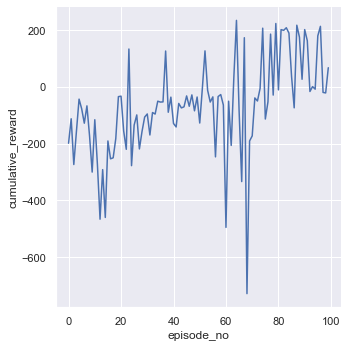

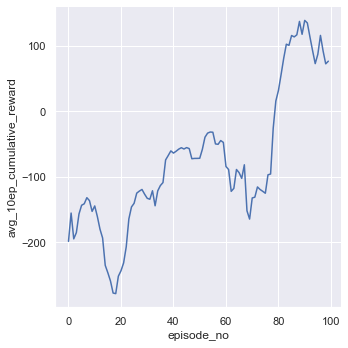

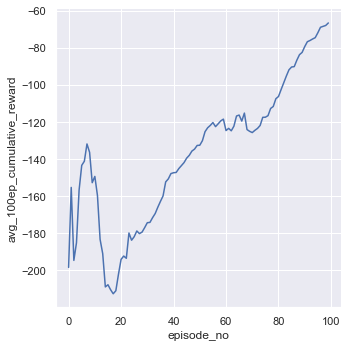

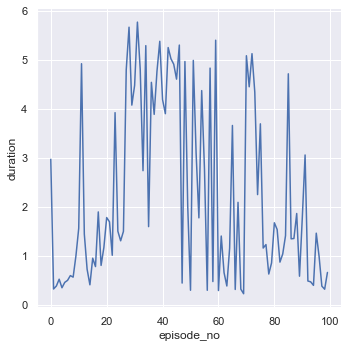

In [11]:
# Now we can visualize the training process
sns.set_theme(style='darkgrid')

# Create a dataframe 
episodes = np.arange(n_games, dtype=np.int32)
df = pd.DataFrame({'episode_no': episodes, 'cumulative_reward': scores, 'avg_10ep_cumulative_reward': avg_10_scores, 
                  'avg_100ep_cumulative_reward': avg_100_scores, 'duration': durations})

# Create plots for the (averaged) rewards and duration of each episode
sns.relplot(x='episode_no', y='cumulative_reward', data=df, kind='line')
sns.relplot(x='episode_no', y='avg_10ep_cumulative_reward', data=df, kind='line')
sns.relplot(x='episode_no', y='avg_100ep_cumulative_reward', data=df, kind='line')
sns.relplot(x='episode_no', y='duration', data=df, kind='line')

In [9]:
# Saves the training data to a csv-file
df.to_csv('results/Pytorch_DQN_1.csv', index=False)

In [15]:
# When executed, this cell will run and render the game for you!

# Number of times to play/render the game
n_instances = 10

for i in range(n_instances):
    # Reset the environment
    obs = env.reset()

    terminal = False
    score = 0
    start_time = time.time()

    # Play until the episode is done
    while not terminal:
        # Render the game
        env.render()
        # Choose an action according to the epsilon-greedy policy of the DQN agent
        action = agent.choose_action(obs)
        # Perform the action, and measure the new state, action, and whether the episode is done
        obs_, reward, terminal, _ = env.step(action)
        # Accumulate the rewards
        score += reward
        # Update the state
        obs = obs_

    duration = time.time() - start_time

    print('Score: {:7.2f}, duration (seconds): {:6.2f}'.format(score, duration))

env.close()

Score:  -11.86, duration (seconds):   2.56
Score:  -20.55, duration (seconds):   1.23
Score:   -0.85, duration (seconds):   1.87
Score:   -5.74, duration (seconds):   3.81
Score:   -3.44, duration (seconds):   1.10
Score:  -30.13, duration (seconds):   3.65
Score:  -19.22, duration (seconds):   6.51
Score:   -0.59, duration (seconds):   5.46
Score:  220.75, duration (seconds):   5.45
Score:  -59.17, duration (seconds):   4.69
